<a href="https://colab.research.google.com/github/gquiro86/ComputoenlaNube/blob/main/Avance_5_EQ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [23]:
from google.colab import drive
drive.mount('/content/drive')
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/ProyectoIntegradorEQ2"
#DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto integrador/Data"
os.chdir(DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Cargar dataset
df = pd.read_csv("Consultas.csv")
df.head()

,Consultas principales,Clics,Impresiones,CTR,Posición
0,precio de cortinas metálicas para negocio,34,1011,3.36%,4.67
1,scosnaya,33,74,44.59%,1.20
2,cuanto cuesta una cortina metálica para negocio,27,1129,2.39%,3.71
3,cortinas de acero precios,26,692,3.76%,5.73
4,precio de cortinas para negocio,20,631,3.17%,3.33


In [25]:
# 1.- Check de valores faltantes, incluyendo valores de mediana en los faltantes.
if df['Posición'].isnull().any():
    median_position = df['Posicion'].median()
    df['Posicion'].fillna(median_position, inplace=True)

In [26]:
# CTR conversión a float y quitando '%'.
df['CTR'] = df['CTR'].astype(str).str.rstrip('%').astype('float') / 100

In [27]:
# 2. Outliers:
q1 = df['Impresiones'].quantile(0.25)
q3 = df['Impresiones'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

#quitando outliers
data = df[(df['Impresiones'] >= lower_bound) & (df['Impresiones'] <= upper_bound)]

In [28]:
#Preparando los valores de X e y - incluyendo OneHotEncoder para convertir consultas principales
X = df.drop('Clics', axis=1)
y = df['Clics']

ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Impresiones', 'Posición', 'CTR']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Consultas principales'])
    ],
    remainder='passthrough'
)


In [29]:
# Define los modelos a evaluar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regression': SVR()
}

# Evaluar los modelos con validación cruzada
def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    return rmse_scores.mean()

# Entrenar y evaluar cada modelo
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('transformer', ct),
        ('regressor', model)
    ])
    rmse = evaluate_model(pipeline, X, y)
    results[name] = rmse
    print(f"Model: {name}, Average RMSE: {rmse}")

# Seleccionamos los dos mejores
sorted_results = sorted(results.items(), key=lambda item: item[1])
top_2_models = sorted_results[:2]

print("\n Los 2 mejores Modelos son: ")
for name, rmse in top_2_models:
    print(f"Modelo:  {name}, Promedio RMSE: {rmse}")

Model: Linear Regression, Average RMSE: 1.7039834913849377
Model: Ridge Regression, Average RMSE: 1.7038131972557964
Model: Lasso Regression, Average RMSE: 1.7049191919119284
Model: Decision Tree, Average RMSE: 1.1727744881263404
Model: Random Forest, Average RMSE: 1.2268710883429315
Model: Gradient Boosting, Average RMSE: 1.2985955504459221
Model: Support Vector Regression, Average RMSE: 1.4067877324088645

 Los 2 mejores Modelos son: 
Modelo:  Decision Tree, Promedio RMSE: 1.1727744881263404
Modelo:  Random Forest, Promedio RMSE: 1.2268710883429315


In [30]:

# Parámetros para Decision Tree y Random Forest
param_grid_dt = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}


# Haremos GridSearchCV para tener el mejor modelo:
def tune_model(model, param_grid, X, y):
    pipeline = Pipeline([
        ('transformer', ct),
        ('regressor', model)
    ])
    # Changed 'Error 2 negativo' to 'neg_mean_squared_error'
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_


# Ajustar Decision Tree
best_dt_model = tune_model(DecisionTreeRegressor(), param_grid_dt, X, y)
print("\n Mejor Modelo de Decisión de Árbol:")
print(best_dt_model)

# Ajustar Random Forest
best_rf_model = tune_model(RandomForestRegressor(), param_grid_rf, X, y)
print("\n Mejor modelo de Random Forest:")
print(best_rf_model)

# Evaluar los mdelos usando validación cruzada
def evaluate_best_model(model, X, y):
    # Changed 'Error 2 negativo' to 'neg_mean_squared_error'
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    return rmse_scores.mean(), rmse_scores

dt_rmse_avg, dt_rmse_scores = evaluate_best_model(best_dt_model, X, y)
rf_rmse_avg, rf_rmse_scores = evaluate_best_model(best_rf_model, X, y)

print(f"\nDecisión de Árbol - RMSE Promedio: {dt_rmse_avg}, RMSE score: {dt_rmse_scores}")
print(f"Random Forest - RMSE Promedio: {rf_rmse_avg}, RMSE score: {rf_rmse_scores}")

# Seleccionamos el mejor modelo, basado en RMSE, después de ajuste
if dt_rmse_avg < rf_rmse_avg:
    final_model = best_dt_model.named_steps['regressor']
else:
    final_model = best_rf_model.named_steps['regressor']

print(f"\n Modelo Final Seleccionado: {type(final_model).__name__}")



 Mejor Modelo de Decisión de Árbol:
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Impresiones', 'Posición',
                                                   'CTR']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Consultas principales'])])),
                ('regressor', DecisionTreeRegressor())])

 Mejor modelo de Random Forest:
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Impresiones', 'Posición',
                                                   'CTR']),
                                   

Basándonos en los resultados obtenidos, y considerando que el DecisionTreeRegressor ha sido seleccionado como el mejor modelo después del proceso de ajuste de hiperparámetros y validación cruzada, podemos concluir que este modelo ofrece un mejor rendimiento en la predicción de la variable objetivo (en este caso, 'Clics') en comparación con el RandomForestRegressor para este conjunto de datos específico. Su menor RMSE promedio indica una menor diferencia entre los valores predichos y los valores reales.



===========================================================
AVANCE 5:

GENERACIÓN DE MODELOS ENSAMBLE
-Bagging
-Voting
-Stacking

In [31]:
import time
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split


# 1.1. Modelo de Bagging usando Árbol de Decisión (modelo homogéneo)
bagging_pipe = Pipeline([
    ('transformer', ct),
    ('bagging', BaggingRegressor(
        # Usamos como estimador base nuestro Árbol de Decisión previamente obtenido; Podemos extraer sus hiperparámetros óptimos.
        estimator=DecisionTreeRegressor(
            max_depth=best_dt_model.named_steps['regressor'].max_depth,
            min_samples_split=best_dt_model.named_steps['regressor'].min_samples_split,
            min_samples_leaf=best_dt_model.named_steps['regressor'].min_samples_leaf
        ),
        n_estimators=50,
        random_state=42))
])

# 1.2. Modelo Voting Regressor (ensamble heterogéneo – blending)
voting_pipe = Pipeline([
    ('transformer', ct),
    ('voting', VotingRegressor(estimators=[
        ('dt', best_dt_model.named_steps['regressor']),
        ('rf', best_rf_model.named_steps['regressor']),
        ('gbr', GradientBoostingRegressor())  # Utilizamos Gradient Boosting con parámetros por defecto
    ]))
])

# 1.3. Modelo Stacking Regressor utilizando los dos mejores modelos individuales
stacking_pipe = Pipeline([
    ('transformer', ct),
    ('stacking', StackingRegressor(
        estimators=[
            ('dt', best_dt_model.named_steps['regressor']),
            ('rf', best_rf_model.named_steps['regressor'])
        ],
        final_estimator=LinearRegression(),
        cv=5
    ))
])

# Guardar los modelos de ensamble en un diccionario
ensemble_models = {
    'Bagging': bagging_pipe,
    'Voting': voting_pipe,
    'Stacking': stacking_pipe
}

In [32]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Para almacenar los resultados
results_ensemble = []

# Evaluar cada modelo de ensamble
for name, model in ensemble_models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results_ensemble.append({
        'Modelo': name,
        'RMSE': rmse,
        'R2': r2,
        'Tiempo_entrenamiento (s)': training_time
    })
    print(f"Modelo: {name}, RMSE: {rmse:.4f}, R2: {r2:.4f}, Tiempo de entrenamiento: {training_time:.4f} s")

# Resultado de los modelos de ensamble
df_ensemble = pd.DataFrame(results_ensemble)

individual_results = []
for model_name, rmse in results.items():
    individual_results.append({
        'Modelo': model_name,
        'RMSE': rmse,
        'R2': 'N/A',
        'Tiempo_entrenamiento (s)': None
    })
df_individual = pd.DataFrame(individual_results)

# Combinar los resultados en una tabla resumen
df_comparativa = pd.concat([df_individual, df_ensemble], ignore_index=True)

# Ordenar la tabla por RMSE
df_comparativa.sort_values(by='RMSE', inplace=True)

print("\nTabla comparativa de modelos:")
print(df_comparativa)

Modelo: Bagging, RMSE: 0.6190, R2: 0.6395, Tiempo de entrenamiento: 0.2547 s
Modelo: Voting, RMSE: 0.5354, R2: 0.7302, Tiempo de entrenamiento: 0.4344 s
Modelo: Stacking, RMSE: 0.6391, R2: 0.6157, Tiempo de entrenamiento: 1.1410 s

Tabla comparativa de modelos:
                      Modelo      RMSE        R2 Tiempo_entrenamiento (s)
8                     Voting  0.535444  0.730234                 0.434368
7                    Bagging  0.618975    0.6395                  0.25471
9                   Stacking  0.639096  0.615682                 1.140951
3              Decision Tree  1.172774       N/A                     None
4              Random Forest  1.226871       N/A                     None
5          Gradient Boosting  1.298596       N/A                     None
6  Support Vector Regression  1.406788       N/A                     None
1           Ridge Regression  1.703813       N/A                     None
0          Linear Regression  1.703983       N/A                     Non

In [33]:
import matplotlib.pyplot as plt

# Seleccionamos el modelo final:
#final_model_name = 'Stacking' //fue 2do.
final_model_name = 'Voting'
final_pipeline = ensemble_models[final_model_name]

# Predecir sobre el set de prueba
y_pred_final = final_pipeline.predict(X_test)
residuos = y_test - y_pred_final


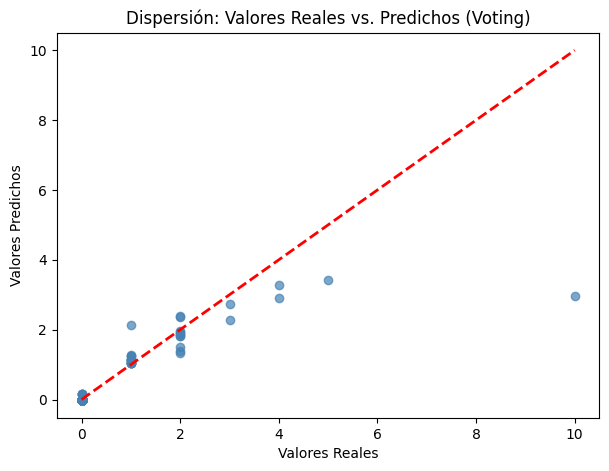

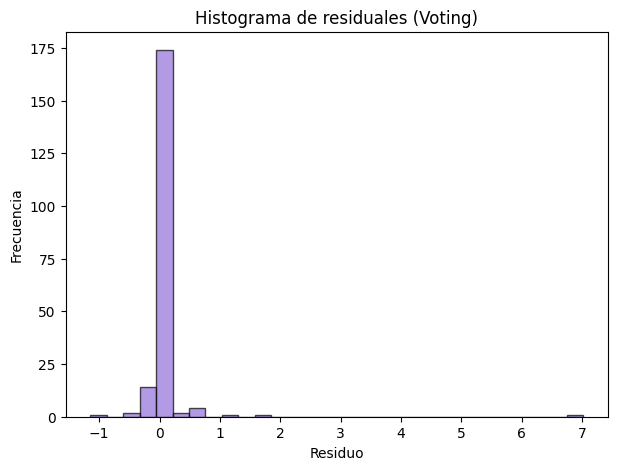

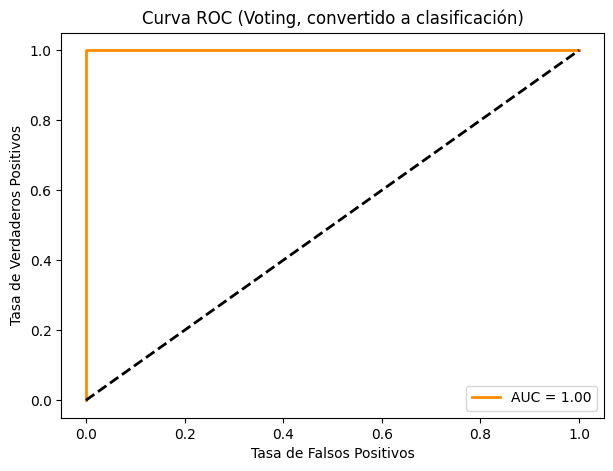

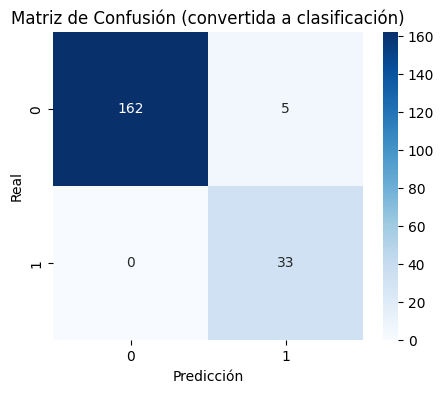

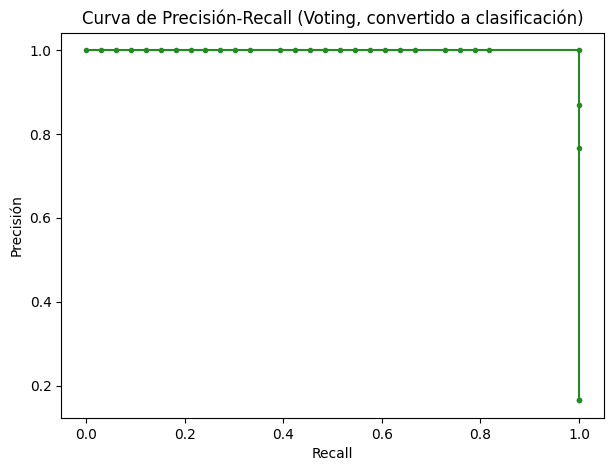

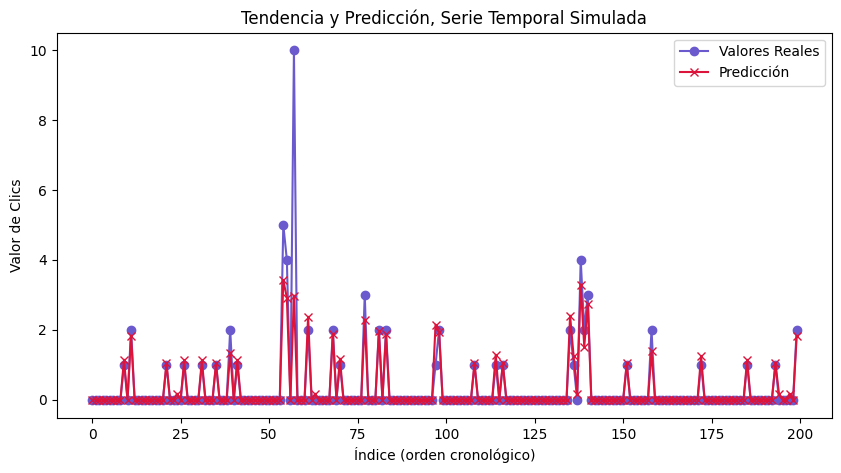

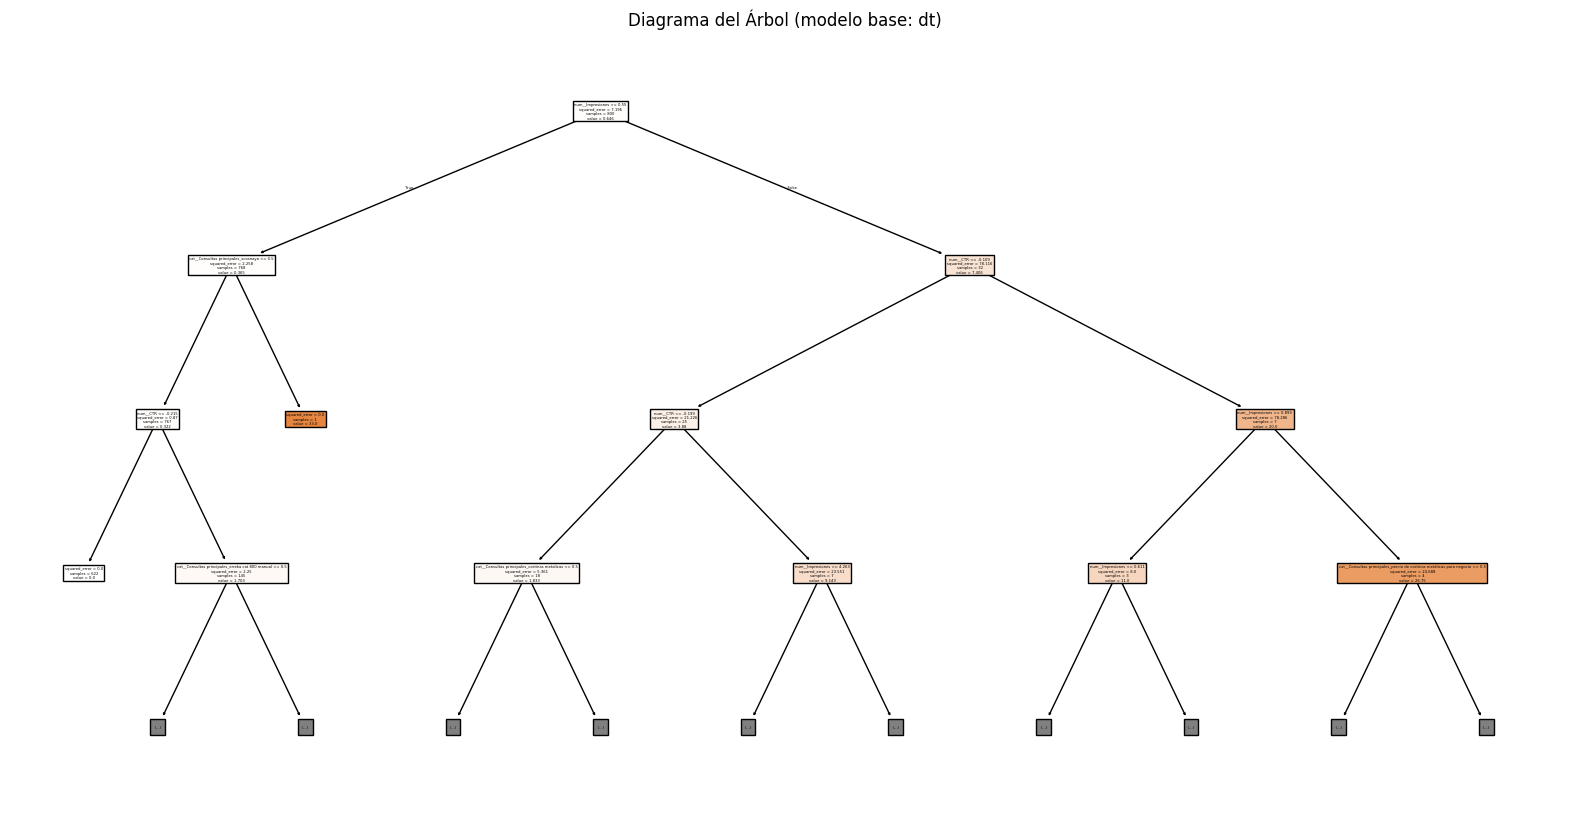

In [35]:
# Obtenemos las predicciones con el modelo Voting
y_pred_voting = voting_pipe.predict(X_test)
residuos = y_test - y_pred_voting

#Gráfico de dispersión: Valores reales vs. Predichos
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_voting, alpha=0.7, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Dispersión: Valores Reales vs. Predichos (Voting)")
plt.show()
#

#Histograma de los residuos
plt.figure(figsize=(7,5))
plt.hist(residuos, bins=30, edgecolor='k', alpha=0.7, color='mediumpurple')
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuales (Voting)")
plt.show()
#

# Se define un umbral para convertir en clasificación: la mediana
umbral = np.median(y_test)
y_test_binary = (y_test > umbral).astype(int)
y_pred_binary = (y_pred_final > umbral).astype(int)

#Curva ROC
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_final)  # Se usan los scores (predicciones de regresión) para ROC
roc_auc = auc(fpr, tpr)


umbral = np.median(y_test)
y_test_bin = (y_test > umbral).astype(int)
y_pred_bin = (y_pred_voting > umbral).astype(int)

#Curva ROC (usando los scores continuos del modelo de regresión)
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_voting)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC (Voting, convertido a clasificación)")
plt.legend(loc="lower right")
plt.show()

#Gráfico Matriz de Confusión
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión (convertida a clasificación)")
plt.show()


#Gráfico Curva de Precisión-Recall
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred_voting)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, marker='.', color='forestgreen')
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Curva de Precisión-Recall (Voting, convertido a clasificación)")
plt.show()

#Gráfico Tendencia vs Predicción
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_test)), y_test, label="Valores Reales", marker='o', color='slateblue')
plt.plot(np.arange(len(y_pred_voting)), y_pred_voting, label="Predicción", marker='x', color='crimson')
plt.xlabel("Índice (orden cronológico)")
plt.ylabel("Valor de Clics")
plt.title("Tendencia y Predicción, Serie Temporal Simulada")
plt.legend()
plt.show()

#Gráfico Árbol de Decisión
estimators_list = voting_pipe.named_steps['voting'].estimators
fitted_estimators = voting_pipe.named_steps['voting'].estimators_
from sklearn import tree

for (nombre, _), modelo in zip(estimators_list, fitted_estimators):
    # Si el modelo base es un Árbol de Decisión, se visualiza uno
    if hasattr(modelo, 'tree_'):
        plt.figure(figsize=(20,10))
        tree.plot_tree(modelo, filled=True, feature_names=voting_pipe.named_steps['transformer'].get_feature_names_out(), max_depth=3)
        plt.title(f"Diagrama del Árbol (modelo base: {nombre})")
        plt.show()
        break  # Se visualiza solo el primer árbol encontrado
else:
    print("No se encontró un modelo base de tipo árbol para visualizar un diagrama de árbol.")

DISPERSIÓN:
En la gráfica de dispersión, se observa que el modelo es efectivo para predecir eventos típicos, con posibles limitaciones en eventos atípicos aunque su capacidad de clasificación binaria se mantiene.

HISTOGRAMA:
En el gráfico de Histograma, observamos que el modelo es efectivo para predecir eventos típicos, como se mostró en el gráfico de dispersión.

CURVA ROC:
En la gráfica de curva, se observar  que el modelo de Voting logra ditinguir entre consultas de alto y bajo rendimiento sin error de clasificación

MATRIZ DE CONFUSIÓN:
En la gráfica de Matriz de Confusión, observamos que de 200 consultas, 195 fueron clasificadas correctamente, con sólo 5 falsos positivos, lo cual indica que su AUC no es exactamente 1.00, como se aprecia en el gráfico de ROC. esto demuestra que el modelo está calibrado y que no presenta falsos negativos.

SERIE TEMPORAL:
En la gráfica de Serie Temporal, logramos ver un pico de 10, que probablemente represente una campaña o evento particular, que logró impactar en las búsquedas.
El modelo demostró capacidad para distinguir entre períodos activos e inactivos, así como predecir la intensidad de los eventos.

ÁRBOL DE DECISIÓN:
En el gráfico de Árbol, podemos observar que su estructura es sencilla y a la vez efectiva - que está relacionada con el AUC 1 y matriz de confusión. El gráfico demuestra decisiones claras que separan efectivamente a las clases.